As part of Udacity's Introduction to Data Analysis course, we will investigate a dataset containing baseball statistics from 1871 to 2015. The dataset used is managed by Sean Lahman and can be found at the following URL: http://www.seanlahman.com/baseball-archive/statistics/. Any references to particular file formats in the rest of this notebook will be to the comma-delimited version of the data.

These baseball data are rather comprehensive and include information about every player from 1871 to 2015. Batting stats, pitching stats, salary information, team information, and more can be found in the various tables. To keep track of an individual player, every player is assigned a unique playerID string. With all this information at our fingertips, what kinds of questions can we answer?

I chose to address two questions here:
1. Is there a prime age for batting success?
2. Is there a significant difference between designated hitter (DH) hitting and pitcher hitting?

I am assuming the reader has a baseline knowledge of baseball, but if not, here is a short summary: teams take turns sending players up to bat against the other team's pitcher wherein the batter (player up to bat) must hit the ball thrown by the pitcher and then run 90 feet to first base. There are some other rules involved, but the gist of it is this: if the player hits the ball and makes it to first base (or beyond), then that at-bat is recorded as a hit. In all other scenarios, the player is not credited with a hit. In this notebook, we will use number of hits and proportion of hits to at-bats as indicators of batting success (the higher, the better). My guess is that there is an age range where batters perform better, perhaps due to a combination of experience and peak physical fitness.

For the second question, a little context about what a designated hitter is may be required. From Wikipedia:
"In baseball, the designated hitter rule is the common name for Major League Baseball Rule 5.11, adopted by the American League in 1973. The rule allows teams to have one player, known as the designated hitter (abbreviated DH), to bat in place of the pitcher."
Conventional wisdom states that pitchers are not great batters. Being able to pick a good batter to replace your pitcher seems like a no-brainer. But, since we have all this data available, can we prove that designated hitters are significantly better at batting than pitchers?

Now that we have some context, let's begin by investigating the dataset to answer our first question. To do so, we will import relevant libraries and load in the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
masterString = "baseballdatabank-master\core\Master.csv"        #change file locations as necessary to
battingString = "baseballdatabank-master\core\Batting.csv"      #re-run calculations
fieldingString = "baseballdatabank-master\core\Fielding.csv"

In [4]:
master = pd.read_csv(masterString, sep=",", header=0)           #create pandas dataframes from relevant files
batting = pd.read_csv(battingString, sep=",", header=0)
fielding = pd.read_csv(fieldingString, sep=",", header=0)

The prior cell blocks, when executed, load in 3 tables. The master table lists each player once with a unique playerID that is used to identify the player in every other table. The full extent of the associated data in the master table is listed in readme2014.txt, but the relevant information is the birth year of each player.

The batting table lists batting statistics. Rows of data are identified by the playerID, the year of play (yearID), the team they played on (teamID), and, if they've played on multiple teams in the same year, the numeric ordering of the team played for in chronological order (stint). Each row also contains batting statistics for that specific player/year/team combination, including hits and at-bats.

The fielding table lists the defensive positions and statistics for players. Similar to the batting table, rows are identified by playerID, yearID, teamID, and stint. As players can play multiple positions for the same team in a year, rows are also identified by the position played by the player (e.g. pitcher, shortstop, and outfielder). Designated hitter is also a position that is listed, and we use this table to identify the players that have batted as a designated hitter.

We can look at the first 5 rows for each of these tables to get a feel for the data.

In [5]:
master.head(5)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,220.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [6]:
batting.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,...,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,...,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,...,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [7]:
fielding.head(5)

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,NaN,NaN,1.0,3.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,NaN,NaN,67.0,72.0,42.0,5.0,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,NaN,NaN,8.0,14.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,NaN,NaN,1.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,NaN,NaN,51.0,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN


Each table is ordered by playerID, and as noted before, the same playerID can appear multiple times in both the batting and fielding tables. To make sure that no two playerID appears multiple times in the master table, we can check the length of the master DataFrame and we can call the Series.unique() function on the playerID column.

In [8]:
len(master)

18846

In [9]:
len(master['playerID'].unique())   #double check that no playerID shows up twice

18846

There are 18846 entries in the master table and 18846 unique player IDs, so no player ID shows up twice in the master table, as expected! Out of curiosity, we can also run the same checks on the batting table. Hopefully there are more batting entries than there are unique player IDs!

In [10]:
len(batting)

101332

In [11]:
len(batting['playerID'].unique())   #players bat in multiple years or for multiple teams in the same year

18659

Interesting, there are ~200 fewer playerIDs in the batting table than in the master table. More would be baffling, but fewer is likely due to some players not having batting statistics at all. This could happen, for example, with a pitcher who only plays one game ever in MLB but does so at an American league stadium where designated hitting is permitted.

As expected, there are more batting entries than unique player IDs. Let's take a look at one of the playerIDs listed near the top of the batting table to see what this looks like.

In [12]:
batting[batting['playerID']=='addybo01']

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,...,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
271,addybo01,1873,1,PH2,NaN,10,51.0,12.0,16.0,1.0,...,10.0,0.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
272,addybo01,1873,2,BS1,NaN,31,152.0,37.0,54.0,5.0,...,36.0,2.0,3.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
396,addybo01,1874,1,HR1,NaN,50,213.0,25.0,51.0,9.0,...,23.0,4.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
521,addybo01,1875,1,PH2,NaN,69,310.0,60.0,80.0,8.0,...,43.0,16.0,8.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
737,addybo01,1876,1,CHN,NL,32,142.0,36.0,40.0,4.0,...,16.0,NaN,NaN,5.0,0.0,NaN,NaN,NaN,NaN,NaN
861,addybo01,1877,1,CN1,NL,57,245.0,27.0,68.0,2.0,...,31.0,NaN,NaN,6.0,5.0,NaN,NaN,NaN,NaN,NaN


In the introduction, I made the postulation that the batting average, or propotion of hits to at-bats, would be our indicator of batting success. We can use the data from the batting table to visualize this. Below is a scatterplot of the number of hits vs. the number of at-bats for every entry in the batting table.

(0, 300)

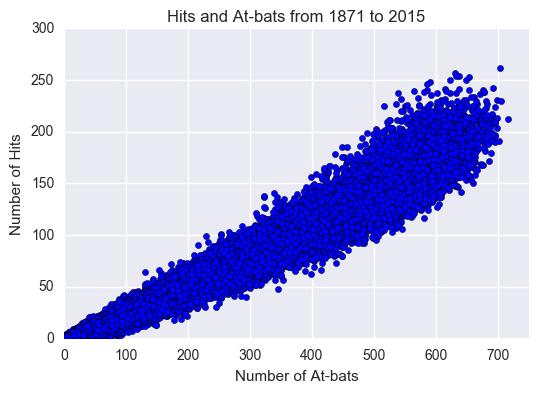

In [13]:
plt.scatter(batting['AB'], batting['H'])
plt.xlabel('Number of At-bats')
plt.ylabel('Number of Hits')
plt.title('Hits and At-bats from 1871 to 2015')
plt.xlim(0,750)
plt.ylim(0,300)

There's definitely an upwards trend in the data, where more at-bats results in more hits, but we can also see that the range of hits becomes larger for higher at-bats. Perhaps more useful would be this same plot as a proportion of hits to at-bats.

(0, 1.05)

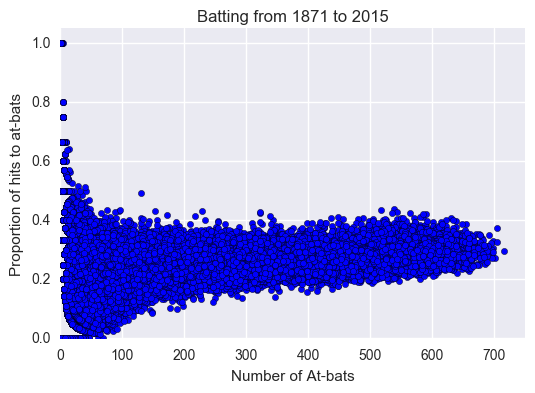

In [14]:
plt.scatter(batting['AB'], batting['H']/batting['AB'])
plt.xlabel('Number of At-bats')
plt.ylabel('Proportion of hits to at-bats')
plt.title('Batting from 1871 to 2015')
plt.xlim(0,750)
plt.ylim(0,1.05)

This visualization shows us that batting averages can vary a significant amount; for batters with more than 200 appearances, the batting average can range between roughly between 10% and 40%.

To investigate the question of whether there's a prime age for batting success, we need to combine the master and batting tables. The master table contains the birth year of the players and the batting table has batting statistics for each year played; we can combine these data to get batting statistics and age. Using the DataFrame.merge() function, we can combine two DataFrames based on corresponding data; in this case, the playerID.

In [15]:
battingMaster = batting.merge(master, on='playerID', how='right')

Let's take a look at the relevant data of the new DataFrame: playerID, the birth year (birthYear), yearID, hits (H), and at-bat appearances (AB).

In [16]:
battingMaster[['playerID', 'birthYear', 'yearID', 'H', 'AB']].head(10)

,playerID,birthYear,yearID,H,AB
0,abercda01,1850.0,1871.0,0.0,4.0
1,addybo01,1842.0,1871.0,32.0,118.0
2,addybo01,1842.0,1873.0,16.0,51.0
3,addybo01,1842.0,1873.0,54.0,152.0
4,addybo01,1842.0,1874.0,51.0,213.0
5,addybo01,1842.0,1875.0,80.0,310.0
6,addybo01,1842.0,1876.0,40.0,142.0
7,addybo01,1842.0,1877.0,68.0,245.0
8,allisar01,1849.0,1871.0,40.0,137.0
9,allisar01,1849.0,1872.0,23.0,87.0


To obtain the age of the player, we subtract birthYear from yearID. To simplify matters, we ignore the month and day of birth and consider simply the age the player becomes during the calendar year. (Luckily for us, this rough approximation can be somewhat justified by the fact that the baseball season stays within the same calendar year, beginning in the spring and ending in November).

In [17]:
battingMaster['Age'] = battingMaster['yearID'] - battingMaster['birthYear']

In [18]:
battingMaster[['playerID', 'Age', 'H', 'AB']].head(10)

,playerID,Age,H,AB
0,abercda01,21.0,0.0,4.0
1,addybo01,29.0,32.0,118.0
2,addybo01,31.0,16.0,51.0
3,addybo01,31.0,54.0,152.0
4,addybo01,32.0,51.0,213.0
5,addybo01,33.0,80.0,310.0
6,addybo01,34.0,40.0,142.0
7,addybo01,35.0,68.0,245.0
8,allisar01,22.0,40.0,137.0
9,allisar01,23.0,23.0,87.0


To get a visualization of the data that will investigate the question at hand, let's graph the mean number of hits in a year vs. the age of the player. To do that, we will use the DataFrame.groupby() function in order to take the mean of every row that has the same age.

In [19]:
hitsByAge = battingMaster.groupby('Age', as_index=False).mean()

In [20]:
hitsByAge.head(10)

,Age,yearID,stint,G,AB,R,H,2B,3B,HR,...,SF,GIDP,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
0,-77.0,1884.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,1961.000000,9.000000,28.000000,1942.000000,7.000000,17.000000,167.000000,NaN
1,-74.0,1887.000000,1.000000,11.000000,42.000000,3.000000,8.000000,0.000000,0.000000,0.000000,...,NaN,NaN,1961.000000,9.000000,28.000000,1942.000000,7.000000,17.000000,167.000000,NaN
2,-71.0,1890.000000,1.000000,24.000000,95.000000,15.000000,28.000000,2.000000,3.000000,0.000000,...,NaN,NaN,1961.000000,9.000000,28.000000,1942.000000,7.000000,17.000000,167.000000,NaN
3,-70.0,1891.000000,1.000000,129.000000,480.000000,101.000000,130.000000,13.000000,14.000000,2.000000,...,NaN,NaN,1961.000000,9.000000,28.000000,1942.000000,7.000000,17.000000,167.000000,NaN
4,-69.0,1892.000000,1.000000,4.000000,15.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,NaN,NaN,1961.000000,9.000000,28.000000,1942.000000,7.000000,17.000000,167.000000,NaN
5,16.0,1902.500000,1.000000,7.833333,28.166667,4.333333,6.666667,1.166667,0.000000,0.000000,...,0.000000,0.000000,1886.500000,3.500000,17.333333,1947.000000,8.600000,18.400000,183.250000,70.400000
6,17.0,1915.148148,1.000000,11.888889,36.777778,4.222222,7.962963,0.888889,0.074074,0.000000,...,0.000000,0.363636,1898.148148,5.296296,13.777778,1953.714286,7.904762,15.333333,170.142857,70.478261
7,18.0,1928.312925,1.034014,11.265306,28.882759,3.372414,6.034483,0.717241,0.331034,0.082759,...,0.021277,0.234568,1910.312925,5.475862,13.746479,1965.280374,6.355140,16.420561,179.985507,71.722628
8,19.0,1927.665810,1.002571,17.143959,45.751309,5.426702,10.193717,1.554974,0.426702,0.395288,...,0.150794,0.908571,1908.665810,5.761039,15.285714,1960.425532,6.248227,15.070922,180.024590,71.784153
9,20.0,1931.415279,1.026445,20.214496,58.975000,7.354000,14.203000,2.098000,0.624000,0.647000,...,0.318681,1.157328,1911.415279,5.968159,15.137412,1957.184593,6.469477,14.922965,179.172165,71.679421


The resulting hitsByAge DataFrame looks mostly nice, except for the 5 rows of negative age. Let's find the source of these reported negative ages, since, as far we know, humans cannot be -77 years young.

In [21]:
battingMaster['Age'].min()

-77.0

In [22]:
battingMaster['Age'].argmin()     #find the location in the combined battingMaster DataFrame of the -77 year old

3829

In [23]:
battingMaster.iloc[3829]          #look at the entry for the -77 year old

playerID         johnsbi01
yearID                1884
stint                    1
teamID                 PHU
lgID                    UA
G                        1
AB                       4
R                        0
H                        0
2B                       0
3B                       0
HR                       0
RBI                    NaN
SB                       0
CS                     NaN
BB                       0
SO                     NaN
IBB                    NaN
HBP                    NaN
SH                     NaN
SF                     NaN
GIDP                   NaN
birthYear             1961
birthMonth               9
birthDay                28
birthCountry           USA
birthState              NJ
birthCity              NaN
deathYear             1942
deathMonth               7
deathDay                17
deathCountry           USA
deathState              PA
deathCity          Chester
nameFirst            Lefty
nameLast           Johnson
nameGiven       William F.
w

Obviously this player, Lefty Johnson, wasn't negative 77 years old when he played baseball. Moreover, the data entry states that he was born in 1961 and died in 1942 at the ripe age of negative 19 years. If we look up Lefty Johnson on Wikipedia (https://en.wikipedia.org/wiki/Lefty_Johnson), it states that he was actually born in 1862, not 1961, while corroborating the death year. We can conclude that the listed birth year is incorrect. All the other negative ages in our data are also probably erroneous, so we will remove them for our subsequent calculations.

In [24]:
hitsByAgeReal = hitsByAge[hitsByAge['Age']>0]

In [25]:
hitsByAgeReal

,Age,yearID,stint,G,AB,R,H,2B,3B,HR,...,SF,GIDP,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
5,16.0,1902.500000,1.000000,7.833333,28.166667,4.333333,6.666667,1.166667,0.000000,0.000000,...,0.000000,0.000000,1886.500000,3.500000,17.333333,1947.000000,8.600000,18.400000,183.250000,70.400000
6,17.0,1915.148148,1.000000,11.888889,36.777778,4.222222,7.962963,0.888889,0.074074,0.000000,...,0.000000,0.363636,1898.148148,5.296296,13.777778,1953.714286,7.904762,15.333333,170.142857,70.478261
7,18.0,1928.312925,1.034014,11.265306,28.882759,3.372414,6.034483,0.717241,0.331034,0.082759,...,0.021277,0.234568,1910.312925,5.475862,13.746479,1965.280374,6.355140,16.420561,179.985507,71.722628
8,19.0,1927.665810,1.002571,17.143959,45.751309,5.426702,10.193717,1.554974,0.426702,0.395288,...,0.150794,0.908571,1908.665810,5.761039,15.285714,1960.425532,6.248227,15.070922,180.024590,71.784153
9,20.0,1931.415279,1.026445,20.214496,58.975000,7.354000,14.203000,2.098000,0.624000,0.647000,...,0.318681,1.157328,1911.415279,5.968159,15.137412,1957.184593,6.469477,14.922965,179.172165,71.679421
10,21.0,1940.835517,1.022804,27.405628,83.254518,10.690763,20.924197,3.221888,0.934739,1.100904,...,0.547213,1.644258,1919.835517,5.963235,15.440435,1959.782820,6.505673,15.296596,181.404738,71.965674
11,22.0,1948.054977,1.024553,33.288231,101.645926,13.140346,25.707031,4.043248,1.138951,1.492467,...,0.705915,2.006676,1926.054977,6.219585,15.469404,1961.686597,6.369208,15.376682,184.061483,72.165843
12,23.0,1954.957620,1.035140,39.240155,119.594529,15.775772,30.795683,5.024377,1.326945,2.015445,...,0.793814,2.391669,1931.957620,6.390084,15.432616,1962.742264,6.529811,15.672707,185.853355,72.313849
13,24.0,1960.246967,1.040612,42.292853,126.288448,16.703450,32.573823,5.361084,1.317921,2.260511,...,0.881399,2.536220,1936.246967,6.441817,15.548146,1964.376489,6.548903,15.613358,187.319400,72.419122
14,25.0,1963.977331,1.049430,46.770320,138.209929,18.291535,35.814425,5.958085,1.389533,2.562580,...,0.941918,2.797433,1938.977331,6.541921,15.614424,1965.712637,6.518717,15.620321,188.491197,72.537574


OK, that looks better. We printed the entire DataFrame because, once grouped, it doesn't take up too much space and it lets us check the tail end of our data to make sure we don't have any centenarians playing baseball.

Now we can make that plot! Again, we are plotting the average number of hits (in a year, by a single player) against the age of the player.

(0, 50)

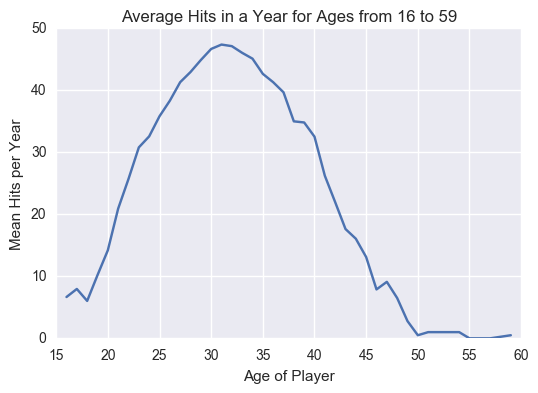

In [26]:
plt.plot(hitsByAgeReal['Age'], hitsByAgeReal['H'])
plt.xlabel('Age of Player')
plt.ylabel('Mean Hits per Year')
plt.title('Average Hits in a Year for Ages from 16 to 59')
plt.xlim(15, 60)
plt.ylim(0, 50)

Looking at the mean hits per year for players of the same age, we find something similar to the normal distribution! The peak hits per year is at 31 years of age. This was just a quick exploration of the data though. Upon thinking more deeply about what we just did, a few problems arise: players can be counted multiple times in the same year (once for each team they played on), and players are weighted equally regardless of how many games they played that year. A more common baseball statistic is the batting average, which is the proportion of hits per at-bat appearance. Let's look at the batting average per age; that is, # hits / # at-bats. To do this, we'll again use groupby, but instead of finding the average hits, we'll sum up the hits and the at-bat appearances by age. Afterwards, we again eliminate the negative ages.


In [27]:
hitsByAgeSummed = battingMaster.groupby('Age', as_index=False).sum()

In [28]:
hitsByAgeSummed = hitsByAgeSummed[hitsByAgeSummed['Age']>0]

In [29]:
hitsByAgeSummed.head(5)

,Age,yearID,stint,G,AB,R,H,2B,3B,HR,...,SF,GIDP,birthYear,birthMonth,birthDay,deathYear,deathMonth,deathDay,weight,height
5,16.0,11415.0,6.0,47.0,169.0,26.0,40.0,7.0,0.0,0.0,...,0.0,0.0,11319.0,21.0,104.0,9735.0,43.0,92.0,733.0,352.0
6,17.0,51709.0,27.0,321.0,993.0,114.0,215.0,24.0,2.0,0.0,...,0.0,4.0,51250.0,143.0,372.0,41028.0,166.0,322.0,3573.0,1621.0
7,18.0,283462.0,152.0,1656.0,4188.0,489.0,875.0,104.0,48.0,12.0,...,1.0,19.0,280816.0,794.0,1952.0,210285.0,680.0,1757.0,24838.0,9826.0
8,19.0,749862.0,390.0,6669.0,17477.0,2073.0,3894.0,594.0,163.0,151.0,...,19.0,159.0,742471.0,2218.0,5778.0,552840.0,1762.0,4250.0,65889.0,26273.0
9,20.0,1971975.0,1048.0,20639.0,58975.0,7354.0,14203.0,2098.0,624.0,647.0,...,116.0,537.0,1951555.0,5998.0,15092.0,1346543.0,4451.0,10267.0,173797.0,69314.0


To obtain the batting average proportion for each age, we simply divide the total number of hits by the total number of at-bats. Then, we can plot against age.

In [30]:
hitsByAgeSummed['battingAverage'] = hitsByAgeSummed['H'] / hitsByAgeSummed['AB']

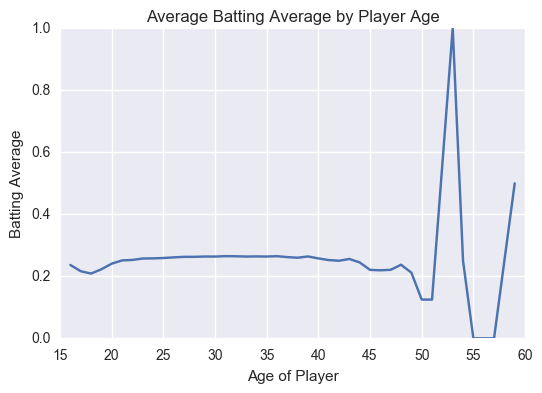

In [31]:
plt.plot(hitsByAgeSummed['Age'], hitsByAgeSummed['battingAverage'])
plt.xlabel('Age of Player')
plt.ylabel('Batting Average')
plt.title('Average Batting Average by Player Age')

The shape of this graph appears to be skewed by the data points of the players aged 50 or higher. Let's take a look at the batting/master table again to see those specific entries.

In [32]:
battingMaster[battingMaster['Age']>=50]

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,Age
854,orourji01,1904.0,1.0,NY1,NL,1.0,4.0,1.0,1.0,0.0,...,James Henry,185.0,68.0,R,R,1872-04-26,1904-09-22,orouj103,o'rouji01,54.0
8701,altroni01,1929.0,1.0,WS1,AL,1.0,1.0,0.0,1.0,0.0,...,Nicholas,197.0,70.0,B,L,1898-07-14,1933-10-01,altrn101,altroni01,53.0
8702,altroni01,1931.0,1.0,WS1,AL,1.0,0.0,0.0,0.0,0.0,...,Nicholas,197.0,70.0,B,L,1898-07-14,1933-10-01,altrn101,altroni01,55.0
8703,altroni01,1933.0,1.0,WS1,AL,1.0,1.0,0.0,0.0,0.0,...,Nicholas,197.0,70.0,B,L,1898-07-14,1933-10-01,altrn101,altroni01,57.0
11361,olearch01,1934.0,1.0,SLA,AL,1.0,1.0,1.0,1.0,0.0,...,Charles Timothy,165.0,67.0,R,R,1904-04-14,1934-09-30,oleac101,o'leach01,59.0
13554,austiji01,1929.0,1.0,SLA,AL,1.0,1.0,0.0,0.0,0.0,...,James Philip,155.0,67.0,B,R,1909-04-19,1929-10-06,austj101,austiji01,50.0
14073,quinnja01,1933.0,1.0,CIN,NL,14.0,1.0,0.0,0.0,0.0,...,John Picus,196.0,72.0,R,R,1909-04-15,1933-07-07,quinj102,quinnja01,50.0
36595,paigesa01,1965.0,1.0,KC1,AL,1.0,1.0,0.0,0.0,0.0,...,Leroy Robert,180.0,75.0,R,R,1948-07-09,1965-09-25,paigs101,paigesa01,59.0
37096,minosmi01,1976.0,1.0,CHA,AL,3.0,8.0,0.0,1.0,0.0,...,Saturnino Orestes Armas,175.0,70.0,R,R,1949-04-19,1980-10-05,minom101,minosmi01,51.0
37097,minosmi01,1980.0,1.0,CHA,AL,2.0,2.0,0.0,0.0,0.0,...,Saturnino Orestes Armas,175.0,70.0,R,R,1949-04-19,1980-10-05,minom101,minosmi01,55.0


We see that there are very few entries for baseball players in their 50s. Moreover, the only 53 year old entry has identically 1 at-bit and 1 hit, resulting in a perfect 1.00 batting average. Let's assume that these data points are outliers and take a look only at those below age 50.

In [33]:
hitsByAgeTruncated = hitsByAgeSummed[hitsByAgeSummed['Age']<50]

(15, 50)

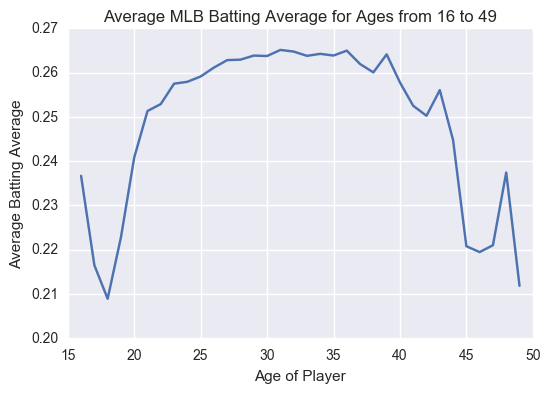

In [34]:
plt.plot(hitsByAgeTruncated['Age'], hitsByAgeTruncated['battingAverage'])
plt.xlabel('Age of Player')
plt.ylabel('Average Batting Average')
plt.title('Average MLB Batting Average for Ages from 16 to 49')
plt.xlim(15, 50)

Similar to the average hits per year, the average batting average appears to be highest in the early 30s. The shape can still be roughly approximated by the normal distribution, albeit much wider (or with a much larger standard deviation). Whereas the prior plot appeared to show that players batted better in their early 30s, this plot appears to show a wider age range for prime batting.

Just out of curiosity, we can also look at this plot only for players of one of my favorite baseball teams: the Oakland Athletics.

In [35]:
oaklandByAge = battingMaster[battingMaster['teamID']=='OAK'].groupby('Age', as_index=False).sum()
oaklandByAge['battingAverage'] = oaklandByAge['H'] / oaklandByAge['AB']

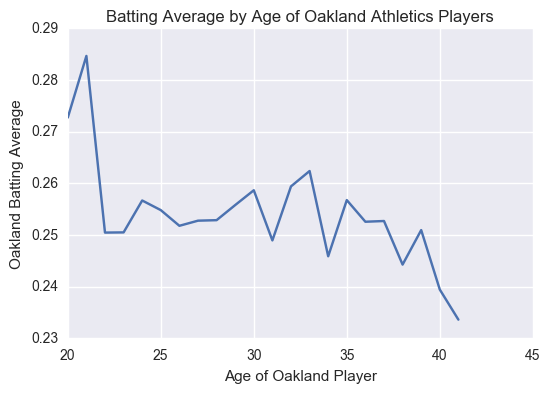

In [36]:
plt.plot(oaklandByAge['Age'], oaklandByAge['battingAverage'])
plt.xlabel('Age of Oakland Player')
plt.ylabel('Oakland Batting Average')
plt.title('Batting Average by Age of Oakland Athletics Players')

No real discernable pattern can be gleamed from this plot; perhaps this means that Oakland players have no real relationship between batting performance and age, or, more likely, perhaps there isn't enough data.

To recap, we posed the question "Is there a prime age for batting success?" Across the data from 1871 to 2015, plotting both the mean number of hits and the mean batting average certainly seem to show peaks in the late 20s to early 30s, suggesting that at the very least, there is a correlation between age and batting success.

Let's take a look at the other question posed at the beginning: the difference in batting between designated hitters and pitchers. Let's look at the first few entries in the fielding table for designated hitters (DH) and pitchers (P).

In [37]:
fielding[fielding["POS"]=="DH"].head(5)

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
76432,adamsmi02,1973,1,MIN,AL,DH,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76450,allenbe01,1973,1,NYA,AL,DH,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76453,allendi01,1973,1,CHA,AL,DH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76476,alouje01,1973,2,OAK,AL,DH,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76486,alouma01,1973,1,NYA,AL,DH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
fielding[fielding["POS"]=="P"].head(5)

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
27,bechtge01,1871,1,PH1,NaN,P,3,NaN,NaN,1.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
39,brainas01,1871,1,WS3,NaN,P,30,NaN,NaN,18.0,28.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN
66,fergubo01,1871,1,NY2,NaN,P,1,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
69,fishech01,1871,1,RC1,NaN,P,24,NaN,NaN,22.0,54.0,6.0,3.0,NaN,NaN,NaN,NaN,NaN
72,fleetfr01,1871,1,NY2,NaN,P,1,NaN,NaN,0.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


Note that the earliest entry for designated hitters is in 1973, which makes sense, as that is the year when designated hitting was added to the American League. In order to avoid lurking variables, such as evolution of the game between 1871 and 1973, let's look only at batting statistics from 1973 onwards. Since we're interested in batting statistics, we'll merge the fielding and battle tables. This time, we'll merge by shared playerID, yearID, teamID, and stint (since unique playerIDs can appear multiple times in each table). And then, we'll keep only the entries from 1973 onwards.

In [39]:
fieldingBatting = fielding.merge(batting, on=['playerID', 'yearID', 'teamID', 'stint'], how='left')
fieldingBatting = fieldingBatting[fieldingBatting['yearID']>=1973]

In [40]:
fieldingBatting[['playerID','yearID', 'POS', 'H', 'AB']].head(10)

,playerID,yearID,POS,H,AB
76426,aaronha01,1973,LF,118.0,392.0
76427,aaronha01,1973,OF,118.0,392.0
76428,aaronha01,1973,RF,118.0,392.0
76429,abbotgl01,1973,P,NaN,NaN
76430,acostcy01,1973,P,0.0,1.0
76431,adamsmi02,1973,CF,14.0,66.0
76432,adamsmi02,1973,DH,14.0,66.0
76433,adamsmi02,1973,LF,14.0,66.0
76434,adamsmi02,1973,OF,14.0,66.0
76435,ageeto01,1973,CF,48.0,204.0


Notice entries 76431 through 76434 are for the same player who played different positions in the same year. As a result of the tables being used, the batting statistics for the entire year with the team are presented at each position. The data do not allow for separating the batting performances by the defensive position played (e.g. outfielder vs. designated hitter), so we will make the assumption that regardless of the position played, the player's overall batting statistics remain the same.

Let's cut the data down to two sets: hitting and at-bat statistics for pitchers and hitting and at-bat statistics for players who have participated as designated hitters.

In [41]:
pitcherHitting = fieldingBatting[fieldingBatting['POS']=='P'][['playerID', 'yearID', 'teamID', 'POS', 'H', 'AB']]
designatedHitting = fieldingBatting[fieldingBatting['POS']=='DH'][['playerID', 'yearID', 'teamID', 'POS', 'H', 'AB']]

In [42]:
pitcherHitting.head(5)

,playerID,yearID,teamID,POS,H,AB
76429,abbotgl01,1973,OAK,P,NaN,NaN
76430,acostcy01,1973,CHA,P,0.0,1.0
76442,akerja01,1973,CHN,P,0.0,7.0
76443,alburvi01,1973,MIN,P,NaN,NaN
76444,alexado01,1973,BAL,P,NaN,NaN


In [43]:
designatedHitting.head(5)

,playerID,yearID,teamID,POS,H,AB
76432,adamsmi02,1973,MIN,DH,14.0,66.0
76450,allenbe01,1973,NYA,DH,13.0,57.0
76453,allendi01,1973,CHA,DH,79.0,250.0
76476,alouje01,1973,OAK,DH,33.0,108.0
76486,alouma01,1973,NYA,DH,147.0,497.0


The designated hitter data look fine, but the pitcher data show some issues, notably that some entries for hits and at-bats are empty. In order to compare the batting success of designated hitters and pitchers, we need pitchers that have actually been at the batting plate. Moreover, in order to get representative samples, let's only look at entries with 10 or more at-bats. We will impose the same condition on the designated hitter dataset.

In [44]:
pitcherHitting.dropna(inplace=True)
pitcherHitting = pitcherHitting[pitcherHitting['AB']>=10]
designatedHitting = designatedHitting[designatedHitting['AB']>=10]
pitcherHitting.head(10)

,playerID,yearID,teamID,POS,H,AB
76512,arlinst01,1973,SDN,P,10.0,60.0
76542,barrji01,1973,SFN,P,10.0,66.0
76589,billija01,1973,CIN,P,6.0,93.0
76600,blassst01,1973,PIT,P,10.0,24.0
76611,bonhabi01,1973,CHN,P,4.0,43.0
76613,borbope01,1973,CIN,P,5.0,15.0
76627,bradlto01,1973,SFN,P,15.0,77.0
76634,brettke01,1973,PHI,P,20.0,80.0
76640,brilene01,1973,PIT,P,14.0,72.0
76669,bryanro01,1973,SFN,P,16.0,95.0


For each dataset, let's calculate the batting average for each entry by dividing the number of hits by the number of at-bats. Afterwards, we can examine the data by creating boxplots for each.

In [45]:
pitcherHitting['battingAverage'] = pitcherHitting['H'] / pitcherHitting['AB']
designatedHitting['battingAverage'] = designatedHitting['H'] / designatedHitting['AB']

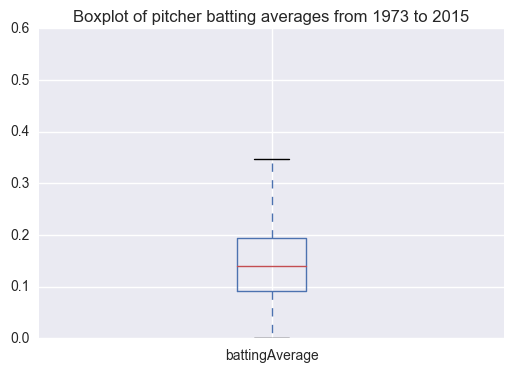

In [46]:
pitcherHitting.boxplot(column = 'battingAverage', return_type='axes')
plt.title('Boxplot of pitcher batting averages from 1973 to 2015')

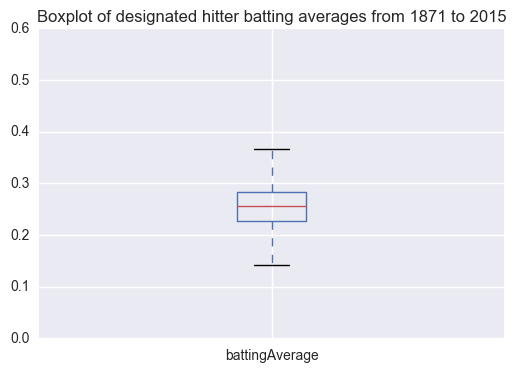

In [47]:
designatedHitting.boxplot(column = 'battingAverage', return_type='axes')
plt.title('Boxplot of designated hitter batting averages from 1871 to 2015')

On inspection, each dataset appears to be roughly normally distributed. Moreover, the batting average of the designated hitters appears to be much better than that of the pitchers. To further quantify this, let's perform a statistical test; specifically, an independent two-sample t-test. This test is appropriate because:

-The two datasets are independent

-We can take random samples from the datasets to perform the t-test

-We are looking at a ratio scale of measurement

-The data are approximately normally distributed (as evidenced by the boxplots)


We will use the following null and alternative hypotheses, respectively:
$$H_0: \mu_{DH} = \mu_{P}$$
$$H_A: \mu_{DH} \neq \mu_{P}$$
where $\mu_{DH}$ is the mean batting average of the designated hitter population and $\mu_{P}$ is the mean batting average of the pitcher population. We will search for significance at the 95% confidence level ($\alpha = 0.05$).

To perform the test, let's use pandas built-in sampling functionality to get 50-sample subsets of data from each population. We'll use the RNG seed 1234 for the random_state variable for reproducibility purposes.

In [48]:
pitcherSample = pitcherHitting.sample(n=50, replace=False, random_state=1234)

In [49]:
pitcherSample

,playerID,yearID,teamID,POS,H,AB,battingAverage
113231,portuma01,1991,HOU,P,9.0,46.0,0.195652
85764,bluevi01,1978,SFN,P,6.0,79.0,0.075949
109895,darliro01,1990,NYN,P,4.0,31.0,0.129032
168092,cosarja01,2015,MIA,P,1.0,17.0,0.058824
82546,houghch01,1976,LAN,P,6.0,21.0,0.285714
136312,mlickda01,2001,HOU,P,3.0,26.0,0.115385
105611,downske01,1988,SFN,P,9.0,54.0,0.166667
101370,darwida01,1986,HOU,P,1.0,16.0,0.062500
118212,whitewa02,1993,SDN,P,2.0,24.0,0.083333
159730,niesejo01,2011,NYN,P,3.0,49.0,0.061224


In [50]:
designatedSample = designatedHitting.sample(n=50, replace=False, random_state=1234)

In [51]:
designatedSample

,playerID,yearID,teamID,POS,H,AB,battingAverage
85760,blankla01,1978,CLE,DH,49.0,193.0,0.253886
116957,huletti01,1993,BAL,DH,78.0,260.0,0.300000
84567,kendafr01,1977,CLE,DH,79.0,317.0,0.249211
121143,hiattph01,1995,KCA,DH,23.0,113.0,0.203540
100183,meierda01,1985,MIN,DH,27.0,104.0,0.259615
83134,pruitro01,1976,CLE,DH,23.0,86.0,0.267442
92491,murphdw01,1981,OAK,DH,98.0,390.0,0.251282
90373,lentiji01,1980,DET,DH,42.0,161.0,0.260870
110216,hamilda02,1990,ML4,DH,46.0,156.0,0.294872
97418,coopece01,1984,ML4,DH,166.0,603.0,0.275290


For two sample sizes of 50, our total degrees of freedom are: (50 - 1) + (50 - 1) = 98. For a one-tailed t-test with 98 degrees of freedom and $\alpha = 0.05, t_{critical} = 1.661$ (as calculated at http://stattrek.com/online-calculator/t-distribution.aspx).

In the code blocks below, we will find the mean, $\overline{x}$, and standard deviation (uncorrected), $s$, for each sample set, and then use the standard deviations to calculate the standard error given by $$SE = \sqrt{\frac{s_{DH}^2}{n_{DH}^2}+\frac{s_{P}^2}{n_{P}^2}}$$
where $n_{DH}$ and $n_P$ are the number of samples in the designated hitter and pitcher sample sets, respectively.

In [52]:
designatedMean = designatedSample['battingAverage'].mean()
designatedSTD = designatedSample['battingAverage'].std(ddof=0)
pitcherMean = pitcherSample['battingAverage'].mean()
pitcherSTD = pitcherSample['battingAverage'].std(ddof=0)

In [53]:
[designatedMean, designatedSTD, pitcherMean, pitcherSTD]

[0.25600135693872067,
 0.04950013392260131,
 0.1379307720892725,
 0.06865240010955215]

In [54]:
standardError = ((designatedSTD/50.0)**2 + (pitcherSTD/50.0)**2)**(0.5)

In [55]:
standardError

0.0016927392355773525

In [56]:
t = (designatedMean - pitcherMean)/standardError

In [57]:
t

69.75119520354069

To summarize, the mean and standard deviations of the samples are
$$\overline{x}_{DH} = 0.2560, S_{DH} = 0.0495$$

$$\overline{x}_P = 0.1379, S_{P} = 0.6865$$

and the standard error is

$$S_{\overline{x}_P-\overline{X}_{DH}} = 0.00169$$

resulting in a t-statistic of

$$t = 69.75$$

The calculated t-statistic (69.75) is greater in magnitude than t-critical (1.661), so we reject the null hypothesis and conclude that the batting performance of designated hitters is significantly better than the batting performance of pitchers at the $\alpha = 0.05$ level.

To recap, I posed two questions in the introduction:
1. Is there a prime age for batting success?
2. Is there a significant difference between designated hitter (DH) hitting and pitcher hitting?

For the first question, the visualizations showed that batters in the late 20s to early 30s experienced better batting success. It seems unlikely that simply being a certain age causes one to bat batter. Players in this prime age range are probably in better physical shape than the youngest players (in their late teens) and the oldest players (in their 40s and 50s). Moreover, there could be some acclimation period required for batters to get used to the highest caliber level of pitching. While looking at batting versus age is interesting because age is a very simple parameter, perhaps it would be more useful to look at batting success versus number of years playing professional baseball.

For the second question, we performed an independent two-sample t-test on batting samples of pitchers and batting sampes of designated hitters. We did find statistical significance that designated hitters bat better than pitchers, but why could that be? Pitchers have to play on both sides of the ball, and they play arguably the most active role in baseball. In 2015, pitchers threw 15.99 pitches per inning on average (source: http://www.sportingcharts.com/mlb/stats/pitching-pitches-per-inning-leaders/2015/). Having to throw high-velocity pitches on one side of the game and then hit speeding fastballs on the other side game certainly sounds tiring, both physically and mentally. On the other hand, designated hitters are just that; their only role in the game is to hit. They aren't in the game at all when their team is on defense, unlike the rest of the batters on their team, so perhaps that extra rest is giving them a boost to their hitting. Naturally, this leads us to re-consider one of our earlier assumptions, which was that players who have played as a designated hitter have the same batting average when playing as a designated hitter or when playing as any other position. Unfortunately, this dataset, while possessing enormous information, is unable to provide us with batting statistics by position played for a player, so we cannot investigate whether our assumption was correct. It would be interesting to compare player batting as designated hitters vs. their batting as other positions, and to repeat our statistical test of pitchers vs. designated hitters with only designated hitter games.